# FreeCAD + Sympy-Mechanics -> Rotating Box

## Imports

In [2]:
from __future__ import division

import FreeCAD as App

import numpy as np
np.set_printoptions(precision=3)

import sympy
from sympy.physics import mechanics
sympy.init_printing()

from pydy.codegen.ode_function_generators import generate_ode_function

from scipy.integrate import odeint

from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = (20.0, 6.0)
%matplotlib inline

from PyQt4 import QtCore
import time

## Helpers

In [3]:
def mat_to_np(mat):
    elements = mat.A
    return np.array([[elements[j * 4 + i] for i in range(4)] for j in range(4)])

def np_to_mat(np_mat):
    App.Matrix(*np_mat.flatten())

def vec_to_np(vec):
    return np.array(list(vec))

## CAD input

In [5]:
rho = 7800 / 1000 ** 3
document = App.getDocument("Rotating_Box")
box = document.Box
inert = mat_to_np(box.Shape.MatrixOfInertia) * rho
mass = box.Shape.Volume * rho
cog = vec_to_np(box.Shape.CenterOfMass)
cog

array([ 5.,  5.,  5.])

## Kinematic

### Reference Frames

In [6]:
I = mechanics.ReferenceFrame("I")
R1 = mechanics.ReferenceFrame("R1")
B = mechanics.ReferenceFrame("B")

In [7]:
theta_x, theta_y = mechanics.dynamicsymbols("theta_x theta_y")
omega_x, omega_y = mechanics.dynamicsymbols("omega_x omega_y")
R1.orient(I, "Axis", (theta_y, I.y))
B.orient(R1, "Axis", (theta_x, R1.x))

In [79]:
R1.set_ang_vel(I, omega_y * R1.y)
B.set_ang_vel(R1, omega_x * B.x)

In [80]:
O = mechanics.Point("O")
box_cog = mechanics.Point("P")
O.set_vel(I, 0)
O.set_vel(R1, 0)
O.set_vel(B, 0)
box_cog.set_pos(O, cog[0] * B.x + cog[1] * B.y + cog[2] * B.z)
box_cog.v2pt_theory(O, I, B)
box_cog.v2pt_theory(O, R1, B)
box_cog.v2pt_theory(O, B, B)

In [81]:
theta = [theta_x, theta_y]
omega = [omega_x, omega_y]

## Inertia

In [82]:
inertia = mechanics.inertia(B, inert[0, 0], inert[1, 1], inert[2, 2])
box_body = mechanics.RigidBody("box", box_cog, B, mass, (inertia, box_cog))

## Loads

In [83]:
g = 9.81
mass_force = -g * mass * I.z

## Equation

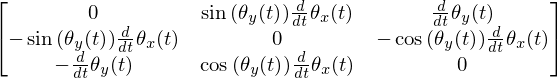

In [84]:
mat = I.dcm(B)
tilde_mat = sympy.simplify(mat.diff("t") * mat.T)
tilde_mat

In [85]:
kin_diff = [omega_x - tilde_mat[2, 1],
            omega_z
            omega_y - tilde_mat[0, 2]]
km = mechanics.KanesMethod(I, theta, omega, kin_diff)
fr, frstar = km.kanes_equations([(box_cog, mass_force)], [box_body])
force = km.forcing_full
mass_matrix = km.mass_matrix_full

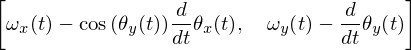

In [76]:
kin_diff

In [93]:
rhs = generate_ode_function(force, theta, omega, [], mass_matrix)
x0 = np.zeros(4)
t = np.linspace(0, 1, 100)

In [94]:
rhs(x0, 0, {})

array([ 0.   ,  0.   , -0.535,  0.535])

In [95]:
y = odeint(rhs, x0, t, args=({},))

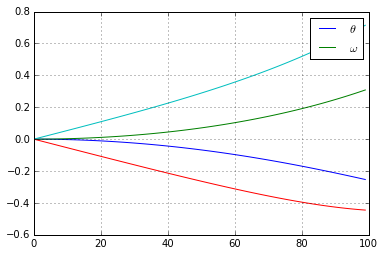

In [96]:
plt.grid()
plt.plot(y)
plt.legend(["$\\theta$", "$\omega$"])


## Visualisation

In [198]:
i = 0
def update(*args):
    global i
    if i == len(y):
        i = 0
    box.Placement.Rotation = App.Rotation(App.Vector(1, 0, 0), np.rad2deg(y[i][0]))
    i += 1

In [193]:
timer = QtCore.QTimer()
timer.setInterval(5)
timer.timeout.connect(update)
timer.start()

In [192]:
timer.stop()
del(timer)